In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

## read data and clean column names

In [3]:
#Spotfire link: 
#https://spotfiremrlprd.merck.com/spotfire/wp/analysis?file=/BOB%20Project%20Support/ELN%20BioAssay/PSCS/Self%20Service%20-%20DPS%20Protein%20Formulation%20Characterization/DPS%20Protein%20Formulation%20Characterization
#os.chdir('c:\\Users\\chenya68\\OneDrive - Merck Sharp & Dohme LLC\\Documents\\gp-data')
df = pd.read_csv('data/dps-alldata.csv')
print(len(df))
df.head()

2743


,Import Date,ISID,Project,Protein,Modality,Control Type,Stress Condition,Temp. (°C),Time (Days),Well ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified Excipients,1st Excipient in Sample,2nd Excipient in Sample,#Conc for Excipient1,Origin of data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [6]:
df.shape

(2743, 98)

In [6]:
# remove special character #,%,(,),.,/
df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df.columns]
df.columns = df.columns.str.replace('Δ', 'chg')

# replace Stir/Stirring with Agitation in the Stress_Condition
df['Stress_Condition'] = df['Stress_Condition'].replace(['Stir','Stirring'],"Agitation")

# Drop out stress studies with limited data 
df.drop(df[df['Stress_Condition'].isin(['Freeze Thaw', 'AAPH', 'tBHP', 'tBPH'])].index, inplace=True)

# Drop out bad data entry
df.drop(df[df['Project'].isnull() & df['Protein'].isnull()].index, inplace=True)

# Some scientist put all information in the sample name,mostly for Trop2 program, more like a robustness study. Drop out for now
df.drop(df[df['Stress_Condition'].isnull() & df['Temp_C_'].isnull()].index, inplace=True)

print(len(df))
#df.to_csv('dps-cleaned-colnames.csv',index = None)

2407


In [7]:
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_','Protein_Conc_mg_mL_']
cols_target = ['UP_SEC_Monomer','UP_SEC_LMW','UP_SEC_HMW']

cols_other_target = ['UP_SEC_chg_Monomer','UP_SEC_chg_LMW','UP_SEC_chg_HMW',
                     'UP_SEC_Abs_chg_Monomer_','UP_SEC_Abs_chg_LMW_',
                     'UP_SEC_Abs_chg_HMW_','UP_SEC_Monomerlabels',
                     'CE_SDS_Red_Purity_Sum','CE_SDS_Red_Purity_Sum',
                     'CE_SDS_Red_chg_Purity','CE_SDS_NR_Purity_Sum',
                     'CE_SDS_NR_chg_Purity','RP_UPLC_Main', 'RP_UPLC_Post_Peak',
                     'RP_UPLC_Pre_Peak','RP_UPLC_chg_Main',
                     'RP_UPLC_chg_Post_Peak', 'RP_UPLC_chg_Pre_Peak']
cols_other = ['_Conc_for_Excipient1','1st_Excipient_in_Sample','2nd_Excipient_in_Sample',
              'BATCH_BIOREG_ID','C_BIOREG_ID','Control_Type','IMPORTED_DATA_FILE_NAME','ISID',
              'Import_Date','Notebook_','Origin_of_data','Project',	'Well_ID']
cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
cols_feature_numeric= ['NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']

In [8]:
# Focus on thermal stress or no stress situation
# Understand the missing values across columns
"""
    Stress studies other than thermal stress are tested for leading formulation, identified by thermal stress. 
    That said, the thermal stress would be the target situation where we could like to optimize the formulation
    We'll focus on thermal stress from now on.
"""
df_other_stress = df[(df['Stress_Condition'] != 'Thermal Stress') & (~df['Stress_Condition'].isnull())]
result = df_other_stress.groupby(['Project','Protein', 'Modality','Stress_Condition'])[cols_feature0].nunique()
result

Buffer  NaCl_mM_  \
Project    Protein        Modality Stress_Condition                         
Surfactant DCC000141_005  ADC      Agitation                  1         1   
           DCC000141_007  ADC      Light stress 0.2 x         1         1   
           DCC000706_005  ADC      Agitation                  1         1   
           MK-1248        mAb      Agitation                  1         1   
                                   G-Force                    1         1   
           MK-4166        mAb      Agitation                  1         1   
           MK-7110        mAb      Agitation                  1         1   
           Trab           ADC      Light stress 0.2 x         1         1   
Tie2       DAB016505_008  mAb      Agitation                  2         2   
                                   Control                    2         2   
                                   High pH                    2         2   
                                   Light Stress 0.2x          2         2   
                                   Light Stress 0.2x CT       2         2   
                                   Low pH                     2         2   
                                   Oxidation                  2         2   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x         1         1   
           DCC000159_003  ADC      Light stress 0.2 x         0         1   
           DCC000238_004  ADC      Light stress 0.2 x         0         1   
           DCC000250_003  ADC      Light stress 0.2 x         0         1   
           DCC000712_002  ADC      Light stress 0.2 x         1         1   
           DCC000770_032  ADC      Agitation                  1         1   

                                                         PS80_  Sucrose_  \
Project    Protein        Modality Stress_Condition                        
Surfactant DCC000141_005  ADC      Agitation                 1         1   
           DCC000141_007  ADC      Light stress 0.2 x        1         1   
           DCC000706_005  ADC      Agitation                 1         1   
           MK-1248        mAb      Agitation                 3         1   
                                   G-Force                   1         1   
           MK-4166        mAb      Agitation                 1         1   
           MK-7110        mAb      Agitation                 1         1   
           Trab           ADC      Light stress 0.2 x        1         1   
Tie2       DAB016505_008  mAb      Agitation                 2         1   
                                   Control                   2         1   
                                   High pH                   2         1   
                                   Light Stress 0.2x         2         1   
                                   Light Stress 0.2x CT      2         1   
                                   Low pH                    2         1   
                                   Oxidation                 2         1   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x        2         2   
           DCC000159_003  ADC      Light stress 0.2 x        1         1   
           DCC000238_004  ADC      Light stress 0.2 x        1         1   
           DCC000250_003  ADC      Light stress 0.2 x        1         1   
           DCC000712_002  ADC      Light stress 0.2 x        1         1   
           DCC000770_032  ADC      Agitation                 1         1   

                                                         Trehalose_  pH  \
Project    Protein        Modality Stress_Condition                       
Surfactant DCC000141_005  ADC      Agitation                      1   2   
           DCC000141_007  ADC      Light stress 0.2 x             1   1   
           DCC000706_005  ADC      Agitation                      1   1   
           MK-1248        mAb      Agitation                      1   1   
                                   G-Force                        1   1   
           

In [9]:
# Focus on thermal stress or no stress
df = df[(df['Stress_Condition'].isnull()) | (df['Stress_Condition'] == 'Thermal Stress')]
print(df['Buffer'].unique())

['Acetate' 'Citrate' 'Histidine' 'Water' 'Phosphate' 'Keytruda' 'Frozen'
 'Bulk Dialysis' 'Glutamate' 'Succinate' '10 mM Histidine']


In [10]:
# Clean the values in 'Buffer' column, remove ambiguous formulation
df['Buffer'] = df['Buffer'].replace('10 mM Histidine',"Histidine")
df.drop(df[df['Buffer'].isin(['Bulk Dialysis', 'Frozen', 'Water','Keytruda' ])].index, inplace=True)

# Fill nan value in Protei concentration with 1mg/ml at which DPS typically run assay 
# DANGER: Double check with DPS/ELN
df['Protein_Conc_mg_mL_'].fillna(1, inplace=True)
print(len(df))

1865


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_55132/297853457.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Protein_Conc_mg_mL_'].fillna(1, inplace=True)


## Distribution of features across all groups

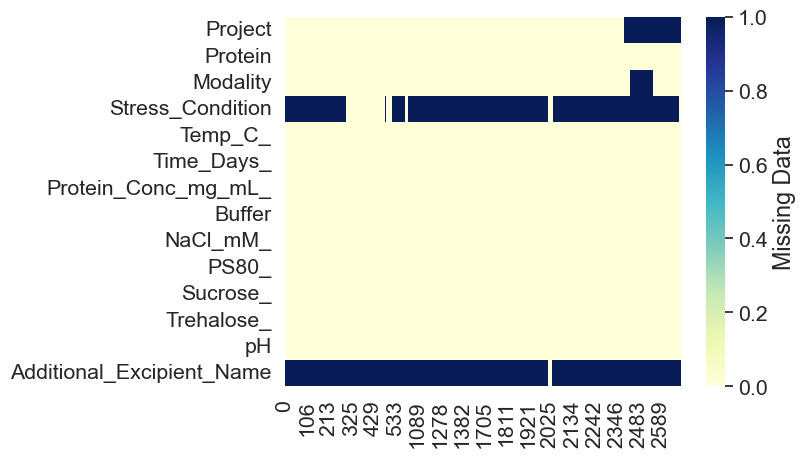

In [11]:
# missing data visualization across identifiers and formulation factors
sns.set(font_scale=1.4)
sns.heatmap(df[cols_group + cols_feature0].isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

NaCl_mM_ [  0  50 150  75]
PS80_ [0.   0.02]
Sucrose_ [0.  7.  9.  7.5 5. ]
Trehalose_ [0 7 9]
pH [5.   6.2  6.8  5.6  5.5  6.5  6.   4.5  5.2  7.4  4.3  4.7  4.85 3.9
 4.4  4.9  5.4  5.63 4.6  5.1  4.2  5.9  6.1  6.7  4.   7.  ]


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcor

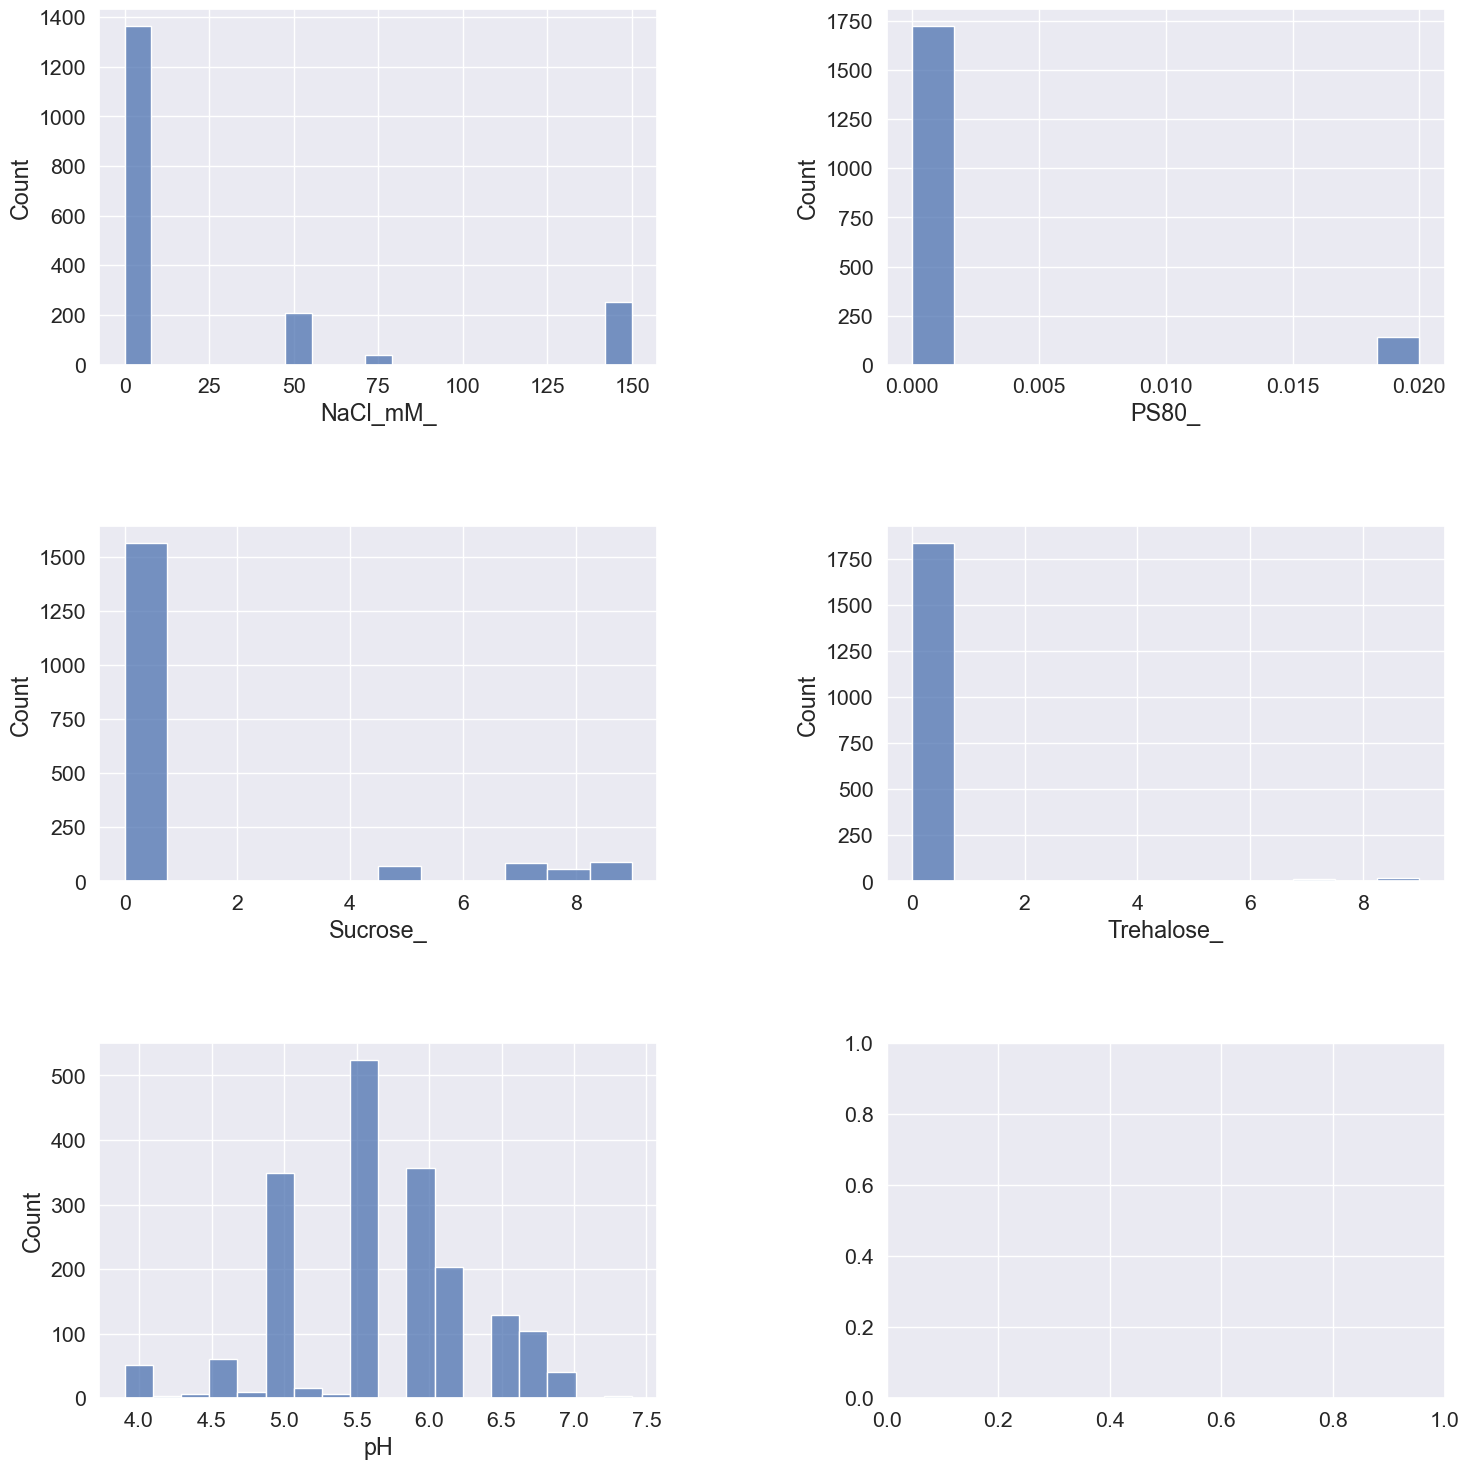

In [12]:
#Distributions of numeric features across all groups
fig, axes = plt.subplots(3,2, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(cols_feature_numeric):
    print(col,df[col].unique())
    sns.histplot(df[col], ax=ax[i]) # histogram call
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

Buffer ['Acetate' 'Citrate' 'Histidine' 'Phosphate' 'Glutamate' 'Succinate']
0


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


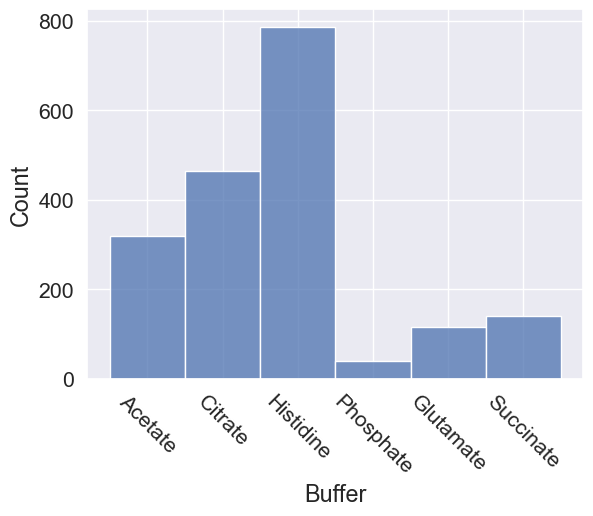

Additional_Excipient_Name [nan '  0.5%MoNi ' ' 1%SBebCD' '002%PO188' '002%PS20' '002%PS80'
 '005%MoNi' '05%MoNI' '1%HPbCD' '1%HPgCD' '1%MoNi' '1%SBEbCD' '1%gCD']
1843


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


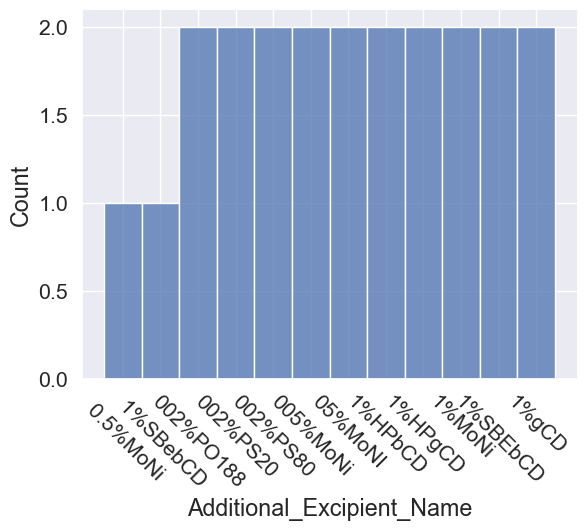

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


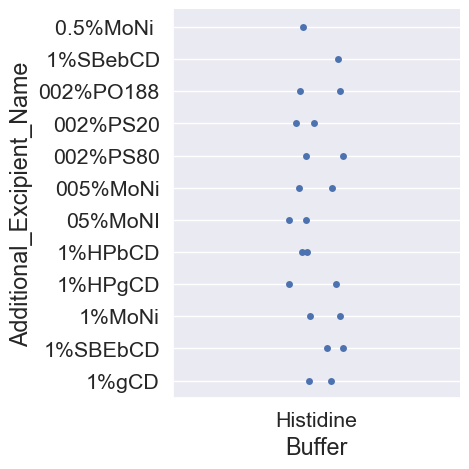

In [13]:
#Distributions of cate features
sns.set(font_scale=1.4)
for i, col in enumerate(['Buffer','Additional_Excipient_Name']):
    print(col,df[col].unique())
    print(df[col].isna().sum())
    #sns.catplot(data=df, x="Buffer", y="pH", jitter=False)
    sns.histplot(df[col]) 
    fig.tight_layout(w_pad=6, h_pad=4) # change padding
    plt.xticks(rotation=-45)
    plt.show()
    #ax[i].set_title(col)
sns.catplot(data=df[~df['Additional_Excipient_Name'].isna()], x="Buffer", y="Additional_Excipient_Name", jitter=True)

In [14]:
# Remove entry with Additional_Excipients

df.drop(df[~df['Additional_Excipient_Name'].isnull()].index, inplace=True)

cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
print(len(df))

1843


## split data into group by identifiers

In [15]:
result = df.groupby(cols_group)['Protein_Conc_mg_mL_'].agg(['min', 'max'])
result

min  \
Project     Protein       Modality Stress_Condition Temp_C_ Time_Days_ Protein_Conc_mg_mL_          
FAP-TriNKET DAB013887     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
                                                     50.0   10.0       1.00                  1.00   
            DAB014071     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
                                                     50.0   10.0       1.00                  1.00   
            DAB014072     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
...                                                                                           ...   
Surfactant  DCC000706_005 ADC      Thermal Stress    40.0   14.0       21.60                21.60   
            Trab          ADC      Thermal Stress   -80.0   0.0        1.61                  1.61   
                                                     40.0   14.0       1.61                  1.61   
Trop2       DCC000770_032 ADC      Thermal Stress    25.0   0.0        5.00                  5.00   
                                                     60.0   5.0        5.00                  5.00   

                                                                                              max  
Project     Protein       Modality Stress_Condition Temp_C_ Time_Days_ Protein_Conc_mg_mL_         
FAP-TriNKET DAB013887     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
                                                     50.0   10.0       1.00                  1.00  
            DAB014071     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
                                                     50.0   10.0       1.00                  1.00  
            DAB014072     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
...                                                                                           ...  
Surfactant  DCC000706_005 ADC      Thermal Stress    40.0   14.0       21.60                21.60  
            Trab          ADC      Thermal Stress   -80.0   0.0        1.61                  1.61  
                                                     40.0   14.0       1.61                  1.61  
Trop2       DCC000770_032 ADC      Thermal Stress    25.0   0.0        5.00                  5.00  
                                                     60.0   5.0        5.00                  5.00  

[136 rows x 2 columns]

In [16]:
# Update the sample identifier 
"""
    The protein concentration may deviate one from another in an acceptable range
    Thus, we remove the Protein concentration from sample identifier
"""
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_']

#get unique levels for identifiers and count for number of missing data

for col in cols_group:
    print(col,'identifier has',df[col].isna().sum(),'missing data points')
    print(df[col].unique())

Project identifier has 272 missing data points
['aTau' 'CD40' 'CEACAM5' 'FAP-TriNKET' 'IL-2Ra' 'Surfactant' 'Sutro IL-2'
 'TRACTr Nectin-4' 'Trop2' nan]
Protein identifier has 0 missing data points
['03BHZ' '69BHV' 'MK-2032' '68BHS' 'TDI' 'AB0411' 'AB0621' '65BKD' '98BLE'
 '99BLE' '64BLJ' 'DAB013887' 'DAB014071' 'DAB014072' 'DAB014074' 'DNB547'
 'DNB553' 'DNB557' 'DNB558' '21BMT' '48BMP' 'DAB015692_013'
 'DCC000492_005' 'DCC000674_005' 'DCC000706_005' 'Trab' 'SP10482'
 'SP009849' 'SP10478' 'SP10784' 'DAB014234' 'DAB014235' 'DAB014236'
 'DAB014238' 'DCC000770_007' 'DAB0156292_012' 'DAB0156292_013'
 'DCC000363_035' 'DCC000770_035' 'DCC000238_004' 'DCC000250_003'
 'DCC000712_002' 'DCC000159_003' 'DCC000770_032' 'DCC_1A' 'DCC_2B'
 'MK3475' 'Enhertu' 'ROR1' 'VLS-101' 'VLS-231']
Modality identifier has 108 missing data points
['mAb' 'BsAb' 'Fusion Protein' 'ADC' 'polymer conjugate' 'Trispecific'
 'Fab' nan]
Stress_Condition identifier has 1609 missing data points
[nan 'Thermal Stress']
Temp_

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


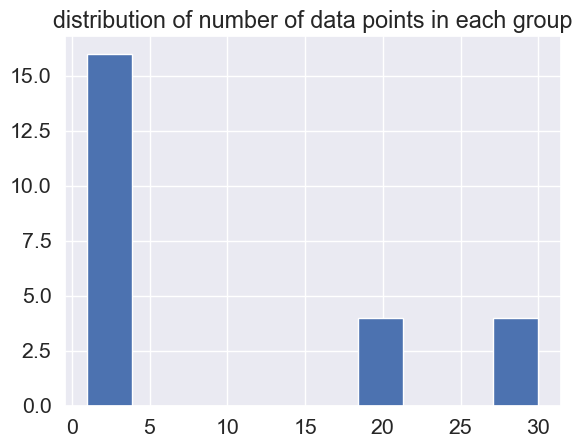

In [17]:
# split dataframe using gropuby
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits = list(df.groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [18]:
group_idx =1
df_sample = splits[group_idx][1]
gname = [str(e) for e in splits[group_idx][0]]

figPath = 'figures2/'+'-'.join(gname)
if not os.path.exists(figPath):
    print(f'Creating folder {figPath}')
    os.makedirs(figPath,exist_ok = True)
df_sample.head()

Creating folder figures2/FAP-TriNKET-DAB013887-BsAb-Thermal Stress-50.0-10.0


,Import_Date,ISID,Project,Protein,Modality,Control_Type,Stress_Condition,Temp_C_,Time_Days_,Well_ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified_Excipients,1st_Excipient_in_Sample,2nd_Excipient_in_Sample,_Conc_for_Excipient1,Origin_of_data
302,12/14/2023,jarvcass,FAP-TriNKET,DAB013887,BsAb,SINGLE CONTROL,Thermal Stress,50.0,10.0,E02,...,8.3,123494.5839,NaN,"FAP_H, NKG2D_H",BsAb,NaN,-,-,1,Protein Formulation Characterization Summary
303,12/14/2023,jarvcass,FAP-TriNKET,DAB013887,BsAb,SINGLE CONTROL,Thermal Stress,50.0,10.0,E03,...,8.3,123494.5839,NaN,"FAP_H, NKG2D_H",BsAb,NaN,-,-,1,Protein Formulation Characterization Summary
304,12/14/2023,jarvcass,FAP-TriNKET,DAB013887,BsAb,SINGLE CONTROL,Thermal Stress,50.0,10.0,E04,...,8.3,123494.5839,NaN,"FAP_H, NKG2D_H",BsAb,NaN,-,-,1,Protein Formulation Characterization Summary
305,12/14/2023,jarvcass,FAP-TriNKET,DAB013887,BsAb,SINGLE CONTROL,Thermal Stress,50.0,10.0,E05,...,8.3,123494.5839,NaN,"FAP_H, NKG2D_H",BsAb,NaN,-,-,1,Protein Formulation Characterization Summary
306,12/14/2023,jarvcass,FAP-TriNKET,DAB013887,BsAb,SINGLE CONTROL,Thermal Stress,50.0,10.0,E06,...,8.3,123494.5839,NaN,"FAP_H, NKG2D_H",BsAb,NaN,-,-,1,Protein Formulation Characterization Summary


In [19]:
#remove target columns that have missing data
cols_target_sample = []
for col in cols_target:
    n_na = df_sample[col].isna().sum()
    if(n_na==0):
        cols_target_sample.append(col)

cols_target_sample

['UP_SEC_Monomer', 'UP_SEC_LMW', 'UP_SEC_HMW']

## Statistical study between target and feature-buffer

In [20]:
splits_buffer = list(df_sample.groupby('Buffer'))
print(len(splits_buffer))
print([len(df[1]) for df in splits_buffer])

3
[6, 6, 9]


/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


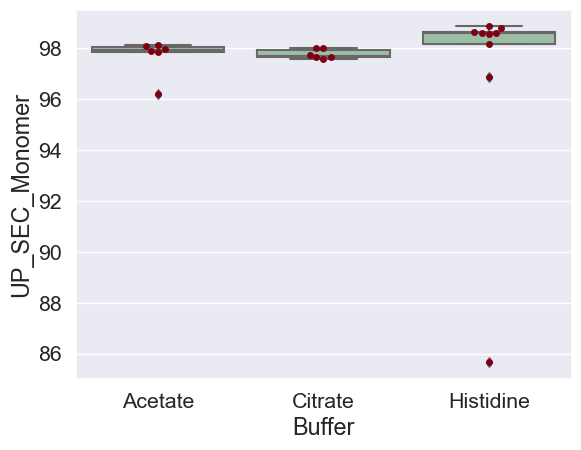

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


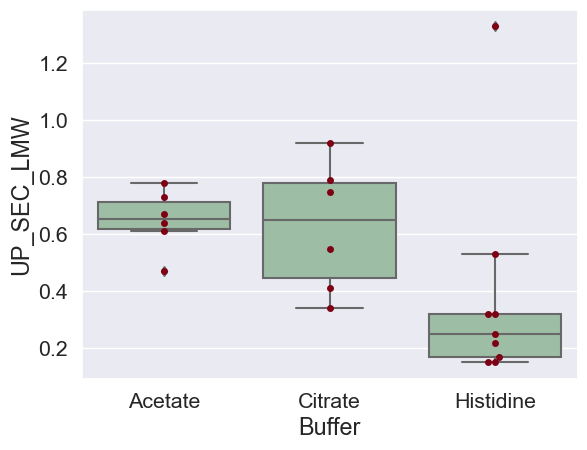

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


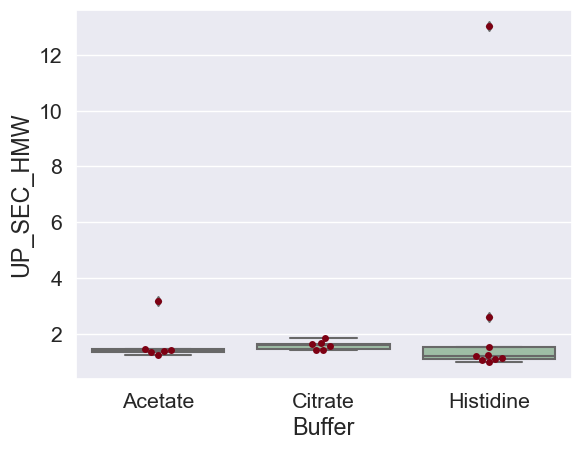

In [21]:
col_x = 'Buffer'
#sns.scatterplot(data=df_sample, x=col_x, y=col_y, hue=col_x)
for col_y in cols_target_sample:
    figName = col_y + '-' + col_x + '_boxplot.jpg'
    ax = sns.boxplot(x=col_x, y=col_y, data=df_sample, color='#99c2a2')
    ax = sns.swarmplot(x=col_x, y=col_y, data=df_sample, color='#7d0013')
    plt.savefig(os.path.join(figPath,figName))
    plt.show()

In [22]:
from pandas import factorize

labels, categories = factorize(df_sample[col_x])
df_sample[col_x+"labels"] = labels
fileName = 'cor_study.txt'
f = open(os.path.join(figPath,fileName), "w")
for col_y in cols_target_sample:
    tmp_cor = abs(df_sample[col_y].corr(df_sample[col_x+"labels"]))
    print('Correlation between' ,col_x , 'and' , col_y , ': ',"{:.2f}".format(tmp_cor),file = f)
f.close()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [23]:
fileName = 'anova_study.txt'
f = open(os.path.join(figPath,fileName), "w")
for col_y in cols_target_sample:
    lm=ols(col_y + ' ~ C(Buffer)', data=df_sample).fit() #Specify C for Categorical
    print('col_y:',col_y,file = f)
    print(sm.stats.anova_lm(lm, typ=2),file = f)
f.close()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## feature preprocessing for a group

In [24]:
#remove feature columns that have missing data
cols_feature1 = []
for col in cols_feature0:
    n_na = df_sample[col].isna().sum()
    if(n_na==0):
        cols_feature1.append(col)

len(cols_feature1)

#split features into numeric and categorical
numeric_feat = df_sample[cols_feature1].select_dtypes(include=[np.number])
print(numeric_feat.shape[1])
cate_feat = df_sample[cols_feature1].select_dtypes(exclude=[np.number])
print(cate_feat.shape[1])

#convert cate features to one-hot encoding
one_hot_cate_feat = pd.get_dummies(cate_feat, columns = ['Buffer'])
#one_hot_cate_feat.head()

5
1


In [25]:
#df_sample_select = pd.concat([numeric_feat,one_hot_cate_feat,df_sample[cols_target_sample[0]]],axis = 1)
df_sample_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
df_sample_feat.shape

(21, 8)

### feature distribution within a group

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcor

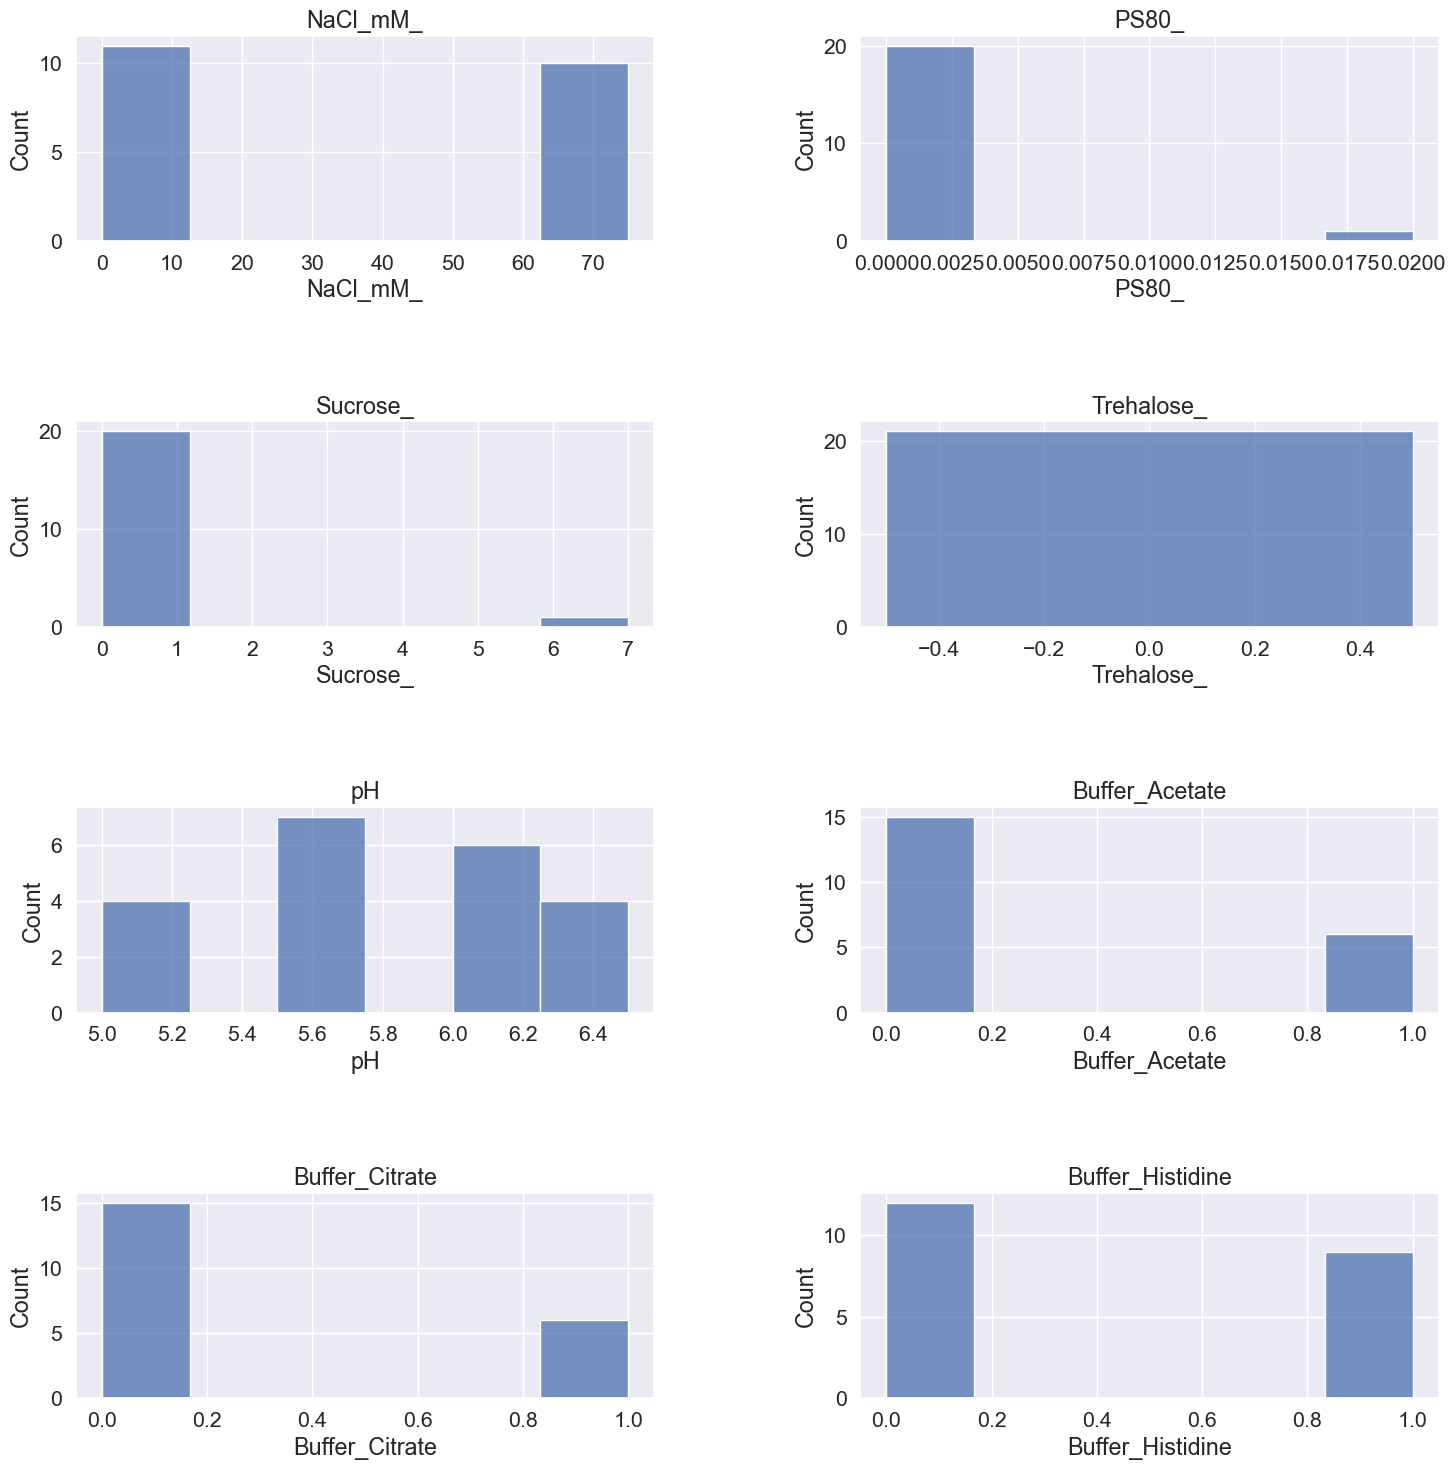

In [26]:

fig, axes = plt.subplots(4,2, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(df_sample_feat.columns):
    sns.histplot(df_sample_feat[col], ax=ax[i]) # histogram call
    ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
figName = 'featureDist.jpg'
plt.savefig(os.path.join(figPath,figName))
plt.show()

### target distribution within a group

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


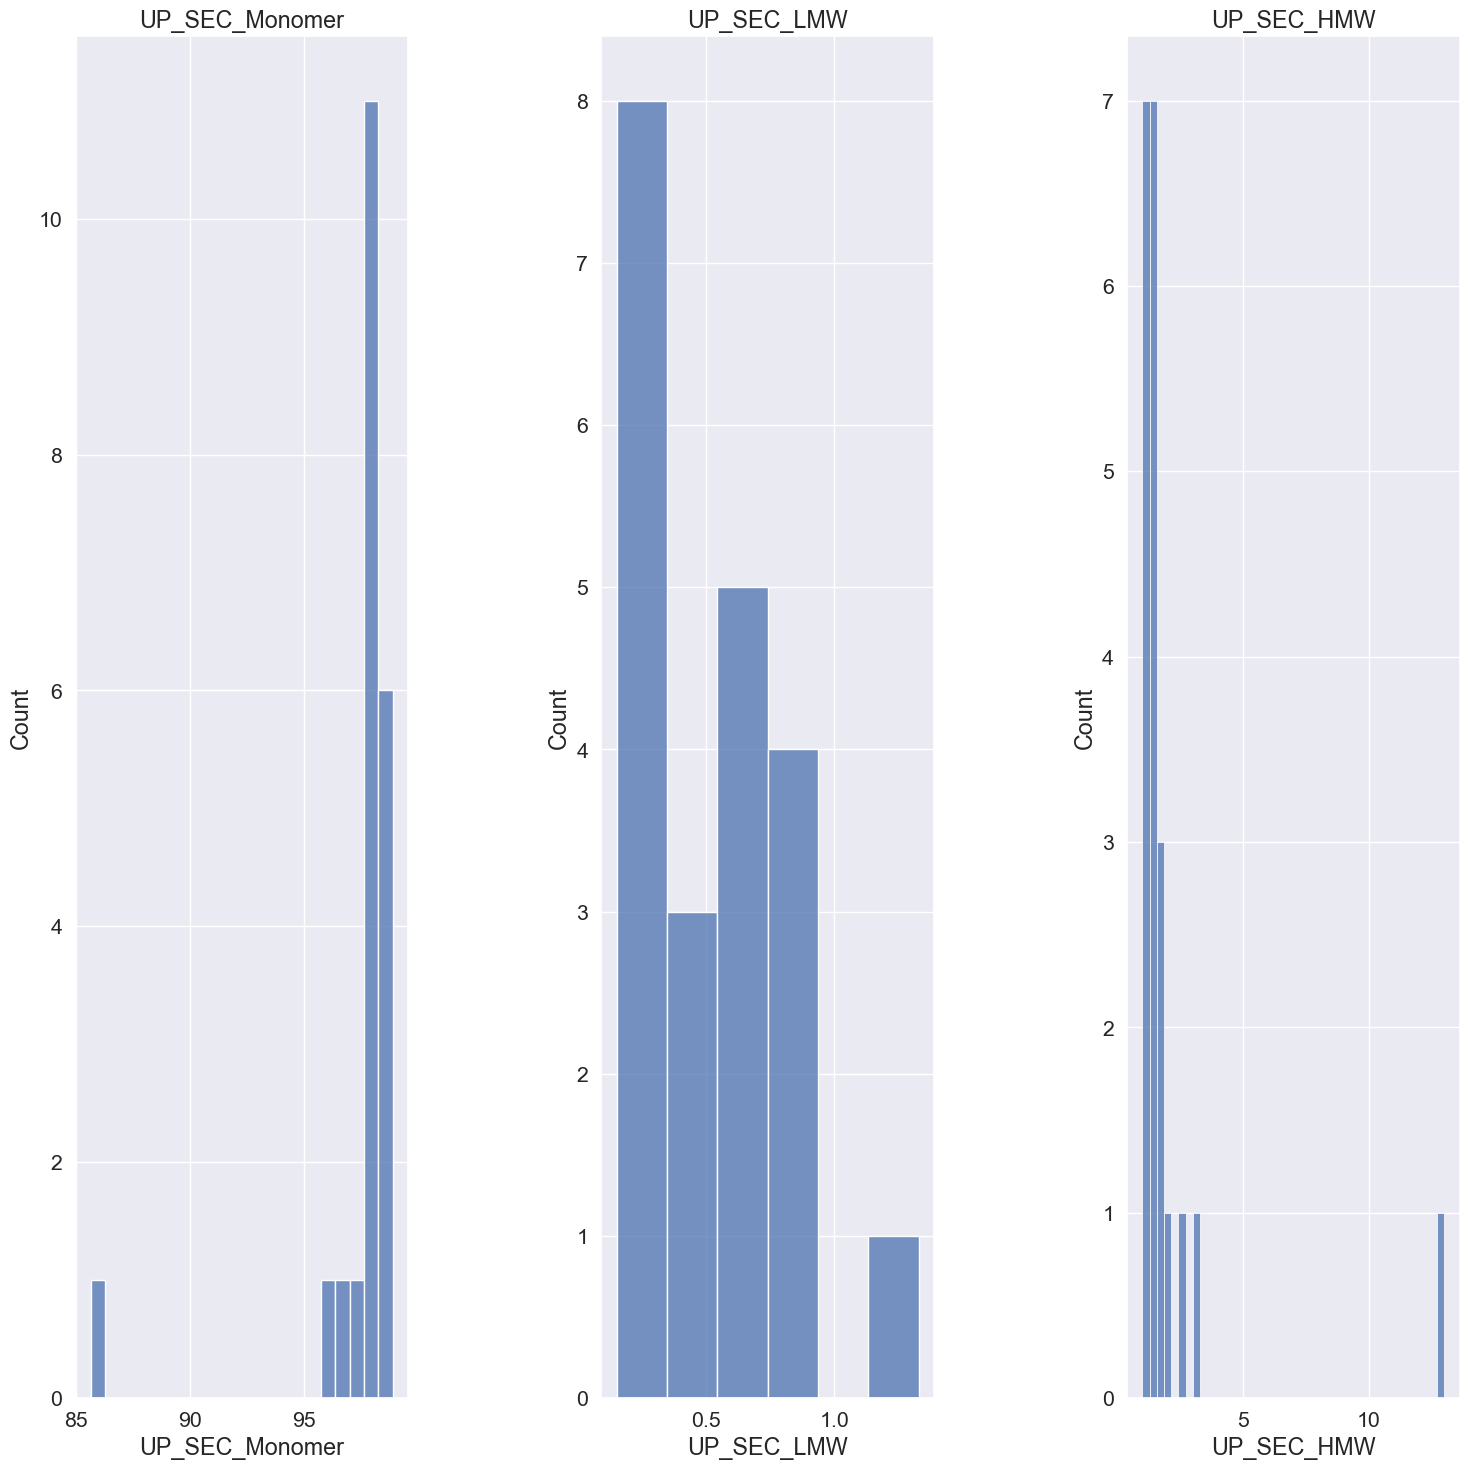

In [27]:
fig, axes = plt.subplots(1,3, figsize=(15, 15))
ax = axes.flatten()

for i, col in enumerate(cols_target_sample):
    sns.histplot(df_sample[col], ax=ax[i]) # histogram call
    ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
figName = 'targetDist.jpg'
plt.savefig(os.path.join(figPath,figName))
plt.show()

## Modeling

In [28]:
# Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_sample_feat, df_sample[cols_target_sample], test_size=0.1, random_state=0)
# scale features
scaler = MinMaxScaler()
X_train=scaler.fit_transform(df_X_train)
X_test=scaler.transform(df_X_test)

feature_names = df_sample_feat.columns

### Random Forest

In [33]:
#sklearn version before 1.4 only has mean_squared_error
import sklearn
print(sklearn.__version__)

1.2.2


AttributeError: module 'sklearn.metrics' has no attribute 'root_mean_squared_error'

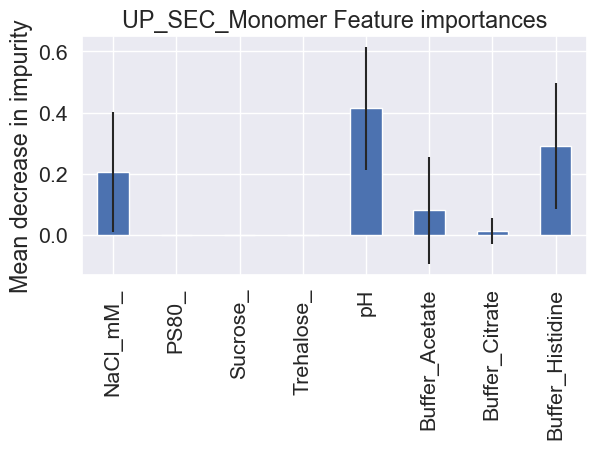

In [31]:
from sklearn import metrics
for tmp_col_y in cols_target_sample:
    rf = RandomForestRegressor()
    #rf.fit(df_sample_feat,df_sample[tmp_col_y])
    rf.fit(X_train,df_y_train[tmp_col_y])
    
    importances=rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title(tmp_col_y + " Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    figName = tmp_col_y + 'featureImp.jpg'
    plt.savefig(os.path.join(figPath,figName))

    

    #y_true = df_sample[tmp_col_y]
    #y_pred = rf.predict(df_sample_feat)
    y_true = df_y_test[tmp_col_y]
    y_pred = rf.predict(X_test)
    fileName = tmp_col_y + '_reg_metrics.txt'
    f = open(os.path.join(figPath,fileName), "w")
    print('Mean Absolute Error (MAE):', "{:.2f}".format(metrics.mean_absolute_error(y_true, y_pred)),file = f)
    print('Mean Squared Error (MSE):', "{:.2f}".format(metrics.mean_squared_error(y_true, y_pred)),file = f)
    print('Root Mean Squared Error (RMSE):', "{:.2f}".format(metrics.root_mean_squared_error(y_true, y_pred)),file = f)
    print('Mean Absolute Percentage Error (MAPE):', "{:.2f}".format(metrics.mean_absolute_percentage_error(y_true, y_pred)),file = f)
    print('Explained Variance Score:', "{:.2f}".format(metrics.explained_variance_score(y_true, y_pred)),file = f)
    print('Max Error:', "{:.2f}".format(metrics.max_error(y_true, y_pred)),file = f)
    print('Mean Squared Log Error:', "{:.2f}".format(metrics.mean_squared_log_error(y_true, y_pred)),file = f)
    print('Median Absolute Error:', "{:.2f}".format(metrics.median_absolute_error(y_true, y_pred)),file = f)
    print('R^2:', "{:.2f}".format(metrics.r2_score(y_true, y_pred)),file = f)
    #print('Mean Poisson Deviance:', "{:.2f}".format(metrics.mean_poisson_deviance(y_true, y_pred)),file = f)
    #print('Mean Gamma Deviance:', "{:.2f}".format(metrics.mean_gamma_deviance(y_true, y_pred)),file = f)
f.close()

### Simple Gaussian Process

In [34]:
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

for tmp_col_y in cols_target_sample:
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    gaussian_process.fit(X_train,df_y_train[tmp_col_y])
    print(gaussian_process.kernel_)
    y_true = df_y_test[tmp_col_y]
    mean_prediction, std_prediction = gaussian_process.predict(X_test, return_std=True)
    y_pred = mean_prediction
    fileName = tmp_col_y + '_gp_metrics.txt'
    f = open(os.path.join(figPath,fileName), "w")
    print('Mean Absolute Error (MAE):', "{:.2f}".format(metrics.mean_absolute_error(y_true, y_pred)),file = f)
    print('Mean Squared Error (MSE):', "{:.2f}".format(metrics.mean_squared_error(y_true, y_pred)),file = f)
    print('Root Mean Squared Error (RMSE):', "{:.2f}".format(metrics.root_mean_squared_error(y_true, y_pred)),file = f)
    print('Mean Absolute Percentage Error (MAPE):', "{:.2f}".format(metrics.mean_absolute_percentage_error(y_true, y_pred)),file = f)
    print('Explained Variance Score:', "{:.2f}".format(metrics.explained_variance_score(y_true, y_pred)),file = f)
    print('Max Error:', "{:.2f}".format(metrics.max_error(y_true, y_pred)),file = f)
    print('Mean Squared Log Error:', "{:.2f}".format(metrics.mean_squared_log_error(y_true, y_pred)),file = f)
    print('Median Absolute Error:', "{:.2f}".format(metrics.median_absolute_error(y_true, y_pred)),file = f)
    print('R^2:', "{:.2f}".format(metrics.r2_score(y_true, y_pred)),file = f)
    #print('Mean Poisson Deviance:', "{:.2f}".format(metrics.mean_poisson_deviance(y_true, y_pred)),file = f)
    #print('Mean Gamma Deviance:', "{:.2f}".format(metrics.mean_gamma_deviance(y_true, y_pred)),file = f)
f.close()

61.3**2 * RBF(length_scale=1.09)


AttributeError: module 'sklearn.metrics' has no attribute 'root_mean_squared_error'